In [19]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import requests
import pandas as pd
import plotly.graph_objs as go
from scipy import stats

In [2]:
with open('keys.txt') as f:
    key = f.readlines()

## Gathering data from api

In [3]:
# API VARIABLES
FUNCTION = 'TIME_SERIES_INTRADAY'
SYMBOL = 'IBM'
INTERVAL = '5min'
OUTPUTSIZE = 'full'

In [4]:
# by default this returns adjusted values
url = f'https://www.alphavantage.co/query?function={FUNCTION}&symbol={SYMBOL}&interval={INTERVAL}&outputsize={OUTPUTSIZE}&apikey={key}'

In [5]:
r = requests.get(url)
data = r.json()

## Processing Data

In [6]:
metaData = data['Meta Data']
timeSeriesData = data[f'Time Series ({INTERVAL})']

In [7]:
df = pd.DataFrame(timeSeriesData).transpose()
df = df.rename(columns = {'1. open': 'open', '2. high' : 'high', '3. low': 'low', '4. close': 'close', '5. volume': 'volume'})

In [8]:
print(df.head())
print(df.info())

                         open      high       low     close volume
2023-08-17 19:55:00  140.2200  140.5300  140.1100  140.1200    277
2023-08-17 19:35:00  140.4600  140.5000  140.4600  140.5000     18
2023-08-17 19:30:00  140.5000  140.5000  140.5000  140.5000      5
2023-08-17 19:20:00  140.2700  140.2700  140.2700  140.2700      1
2023-08-17 19:05:00  140.4500  140.4500  140.4500  140.4500      1
<class 'pandas.core.frame.DataFrame'>
Index: 3219 entries, 2023-08-17 19:55:00 to 2023-07-20 04:00:00
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   open    3219 non-null   object
 1   high    3219 non-null   object
 2   low     3219 non-null   object
 3   close   3219 non-null   object
 4   volume  3219 non-null   object
dtypes: object(5)
memory usage: 150.9+ KB
None


<div class="alert alert-block alert-warning">
<b>Warning:</b> Note all columns are objects. Need to convert objects to numeric type to be able to perform actions on the data
</div>

In [9]:
df = df.astype(float)
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 3219 entries, 2023-08-17 19:55:00 to 2023-07-20 04:00:00
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   open    3219 non-null   float64
 1   high    3219 non-null   float64
 2   low     3219 non-null   float64
 3   close   3219 non-null   float64
 4   volume  3219 non-null   float64
dtypes: float64(5)
memory usage: 150.9+ KB
None


In [10]:
# Check for missing values
print(df.isnull().sum())

# Drop rows with missing values
data_cleaned = df.dropna()

# Fill missing values with specific values
data_filled = df.fillna(value=0)  # Replace with 0, for example

open      0
high      0
low       0
close     0
volume    0
dtype: int64


In [11]:
# Calculate additional features like price change and returns
data_cleaned['price_change'] = data_cleaned['close'] - data_cleaned['open']
data_cleaned['returns'] = (data_cleaned['close'] - data_cleaned['open']) / data_cleaned['open']

## EDA

In [12]:
# Calculate basic statistics
statistics = data_cleaned.describe()

# Display statistics in a user-friendly format
statistics_display = statistics.transpose()

print("Basic Statistics for Stock Data:")
print(statistics_display[['mean', 'std', 'min', '25%', '50%', '75%', 'max']])

Basic Statistics for Stock Data:
                      mean            std         min         25%  \
open            141.265347       2.365694  132.061000  139.975000   
high            141.351425       2.357430  132.137000  140.032000   
low             141.167390       2.390680  128.805000  139.887000   
close           141.256139       2.372736  128.806000  139.928500   
volume        47896.392358  179956.624464    1.000000   43.000000   
price_change     -0.009208       0.293204  -13.913000   -0.052000   
returns          -0.000064       0.002068   -0.097485   -0.000373   

                       50%           75%           max  
open            141.898000    142.917000  1.452500e+02  
high            141.980000    142.983000  1.459100e+02  
low             141.830000    142.833000  1.449000e+02  
close           141.896000    142.904000  1.459100e+02  
volume        17001.000000  36417.000000  4.009455e+06  
price_change     -0.012000      0.047000  2.816000e+00  
returns        

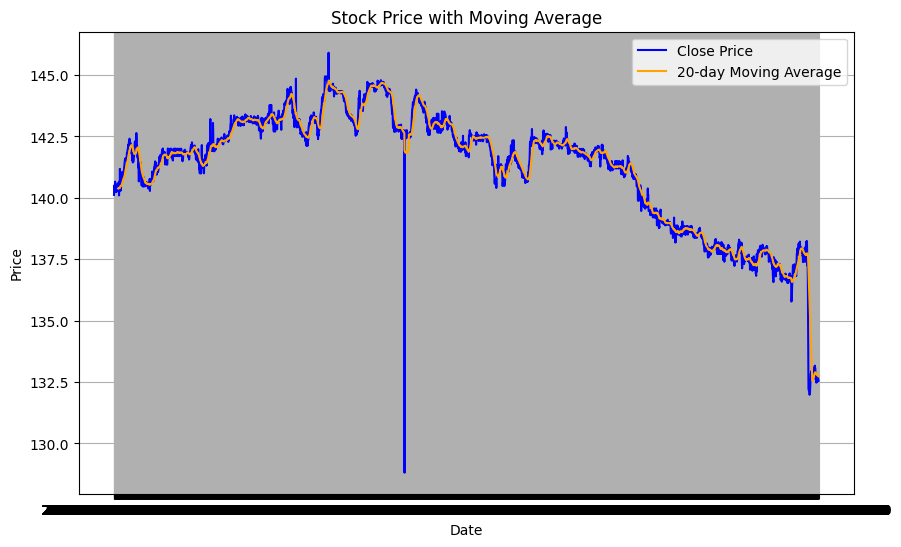

In [17]:
data_cleaned['20MA'] = data_cleaned['close'].rolling(window=20).mean()

# Plot closing price and moving average
plt.figure(figsize=(10, 6))
plt.plot(data_cleaned.index, data_cleaned['close'], label='Close Price', color='blue')
plt.plot(data_cleaned.index, data_cleaned['20MA'], label='20-day Moving Average', color='orange')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Stock Price with Moving Average')
plt.legend()
plt.grid()
plt.show()

Empty DataFrame
Columns: [open, high, low, close, volume, price_change, returns, 20MA, SMA_20, EMA_12, rolling_std, upper_band, lower_band, EMA_26, MACD, Signal_Line, RSI, MACD_Histogram, %K, %D]
Index: []


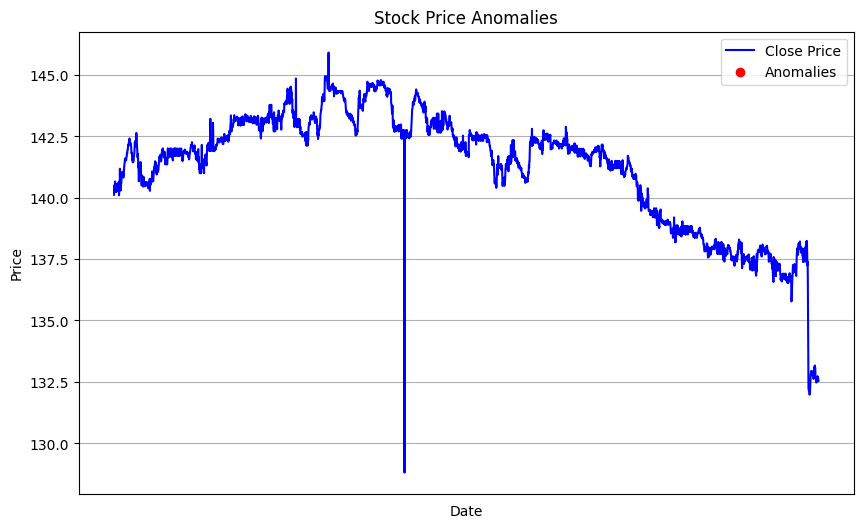

In [29]:
z_scores = stats.zscore(data_cleaned['close'])

# Identify and plot anomalies
anomalies = data_cleaned[z_scores > 3]
print(anomalies) # Threshold for anomalies
plt.figure(figsize=(10, 6))
plt.plot(data_cleaned.index, data_cleaned['close'], label='Close Price', color='blue')
plt.scatter(anomalies.index, anomalies['close'], color='red', label='Anomalies')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Stock Price Anomalies')
plt.legend()
plt.grid()
plt.xticks([])
plt.show()

In [14]:
# Create candlestick chart using Plotly
candlestick = go.Candlestick(
    x=data_cleaned.index,
    open=data_cleaned['open'],
    high=data_cleaned['high'],
    low=data_cleaned['low'],
    close=data_cleaned['close'],
    increasing=dict(line=dict(color='green')),
    decreasing=dict(line=dict(color='red'))
)

layout = go.Layout(
    title='Candlestick Chart - Stock Price',
    xaxis=dict(title='Date'),
    yaxis=dict(title='Price')
)

figure = go.Figure(data=[candlestick], layout=layout)
figure.show()

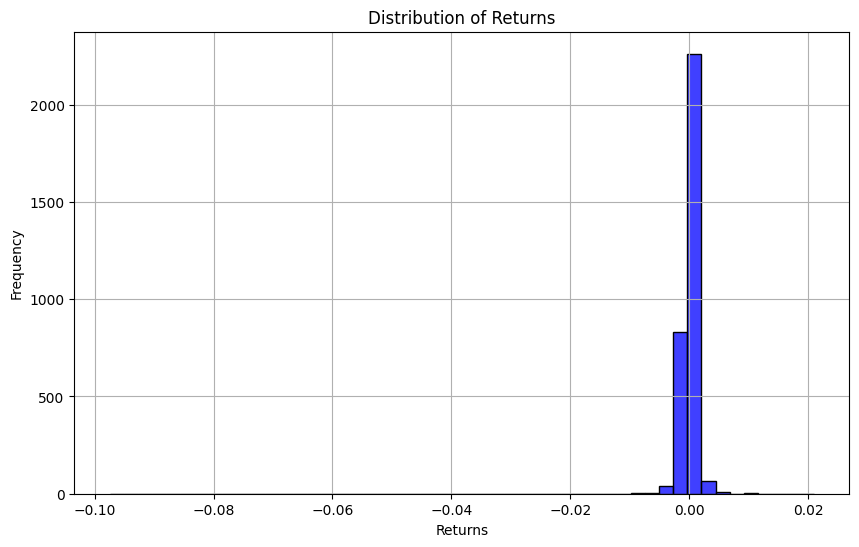

In [21]:
plt.figure(figsize=(10, 6))
sns.histplot(data_cleaned['returns'], bins=50, kde=False, color='blue')
plt.xlabel('Returns')
plt.ylabel('Frequency')
plt.title('Distribution of Returns')
plt.grid()
plt.show()

C:\Users\archi\AppData\Local\Temp\ipykernel_85124\433943804.py:3: FutureWarning:



`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.




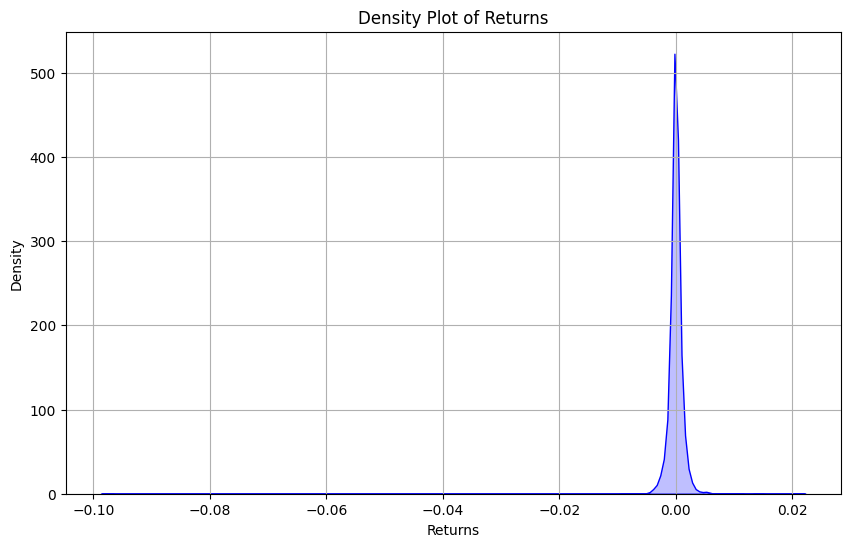

In [22]:
# Plot density plot of returns
plt.figure(figsize=(10, 6))
sns.kdeplot(data_cleaned['returns'], color='blue', shade=True)
plt.xlabel('Returns')
plt.ylabel('Density')
plt.title('Density Plot of Returns')
plt.grid()
plt.show()

## Techincal Indicators

In [26]:
import ta

In [ ]:
# simple moving averages
data_cleaned['SMA_20'] = data_cleaned['close'].rolling(window=20).mean()
data_cleaned['SMA_50'] = data_cleaned['close'].rolling(window=50).mean()
data_cleaned['SMA_200'] = data_cleaned['close'].rolling(window=200).mean()

plt.figure(figsize=(18, 6))
plt.plot(data_cleaned.index, data_cleaned['close'], label='Close Price')
plt.plot(data_cleaned.index, data_cleaned['SMA_20'], label='SMA 20')
plt.plot(data_cleaned.index, data_cleaned['SMA_50'], label='SMA 50')
plt.plot(data_cleaned.index, data_cleaned['SMA_200'], label='SMA 200')
plt.bar(data_cleaned.index, data_cleaned['volume'], label='volume')
plt.title('Stock Price with Moving Averages')
plt.xticks([])
plt.legend()

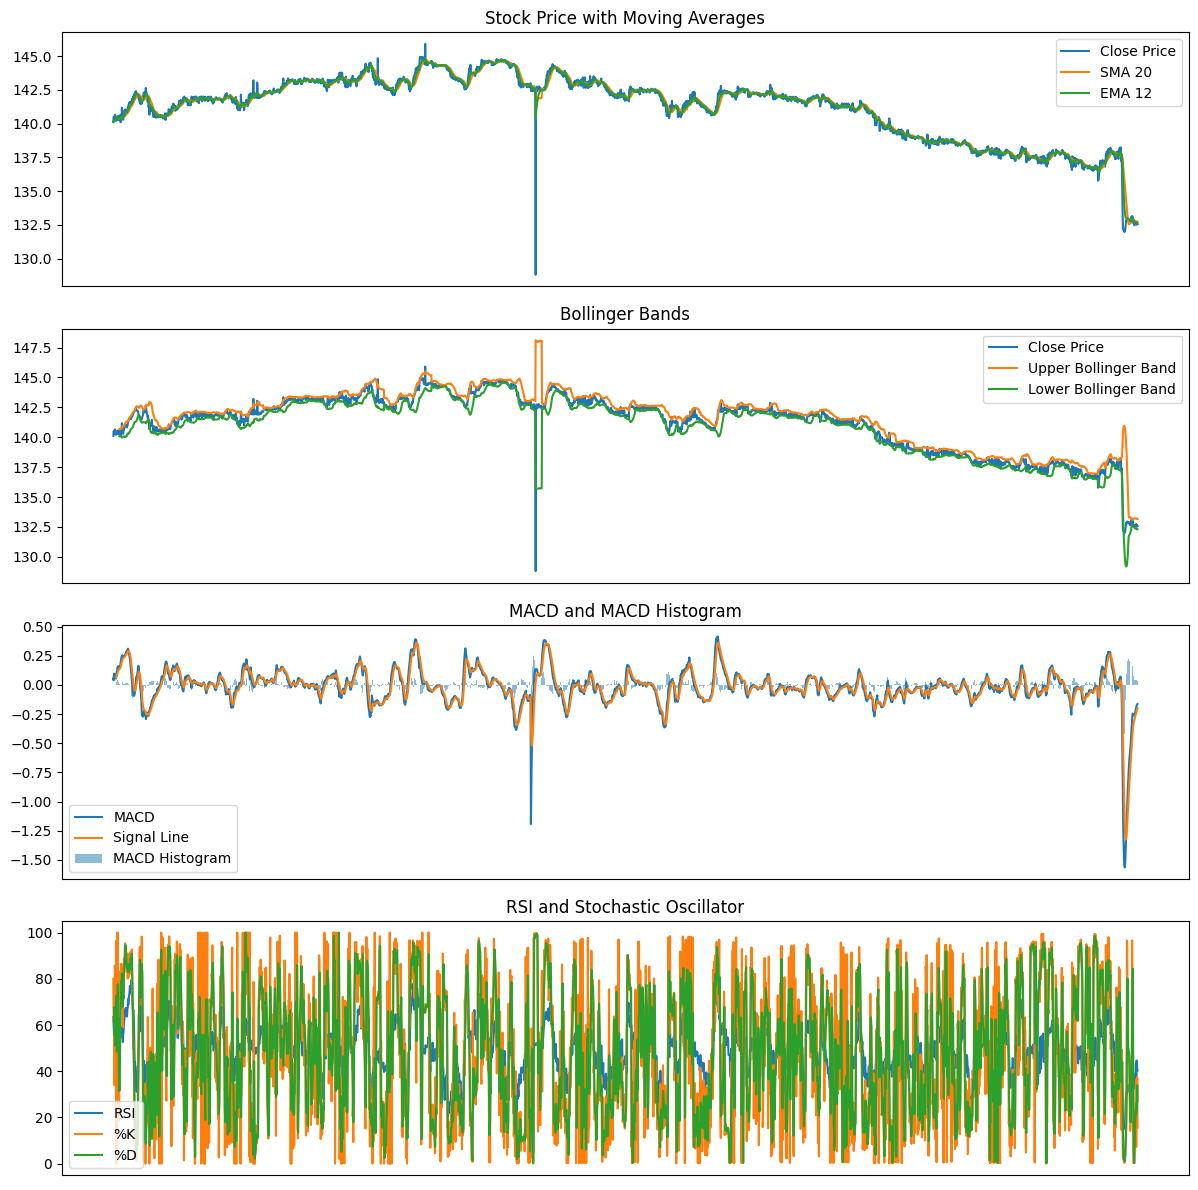

In [28]:
# Calculate Moving Averages (SMA and EMA)




data_cleaned['EMA_12'] = data_cleaned['close'].ewm(span=12, adjust=False).mean()

# Calculate Bollinger Bands
data_cleaned['rolling_std'] = data_cleaned['close'].rolling(window=20).std()
data_cleaned['upper_band'] = data_cleaned['SMA_20'] + (2 * data_cleaned['rolling_std'])
data_cleaned['lower_band'] = data_cleaned['SMA_20'] - (2 * data_cleaned['rolling_std'])

# Calculate MACD and MACD Histogram
macd = ta.trend.MACD(data_cleaned['close'])
data_cleaned['MACD'] = macd.macd()
data_cleaned['Signal_Line'] = macd.macd_signal()
data_cleaned['MACD_Histogram'] = macd.macd_diff()

# Calculate RSI (Relative Strength Index)
data_cleaned['RSI'] = ta.momentum.RSIIndicator(data_cleaned['close']).rsi()

# Calculate Stochastic Oscillator
stochastic = ta.momentum.StochasticOscillator(data_cleaned['high'], data_cleaned['low'], data_cleaned['close'])
data_cleaned['%K'] = stochastic.stoch()
data_cleaned['%D'] = stochastic.stoch_signal()

# Plot the indicators
plt.figure(figsize=(12, 12))

plt.subplot(4, 1, 1)
plt.plot(data_cleaned.index, data_cleaned['close'], label='Close Price')
plt.plot(data_cleaned.index, data_cleaned['SMA_20'], label='SMA 20')
plt.plot(data_cleaned.index, data_cleaned['EMA_12'], label='EMA 12')
plt.title('Stock Price with Moving Averages')
plt.xticks([])
plt.legend()

plt.subplot(4, 1, 2)
plt.plot(data_cleaned.index, data_cleaned['close'], label='Close Price')
plt.plot(data_cleaned.index, data_cleaned['upper_band'], label='Upper Bollinger Band')
plt.plot(data_cleaned.index, data_cleaned['lower_band'], label='Lower Bollinger Band')
plt.title('Bollinger Bands')
plt.xticks([])
plt.legend()

plt.subplot(4, 1, 3)
plt.plot(data_cleaned.index, data_cleaned['MACD'], label='MACD')
plt.plot(data_cleaned.index, data_cleaned['Signal_Line'], label='Signal Line')
plt.bar(data_cleaned.index, data_cleaned['MACD_Histogram'], label='MACD Histogram', alpha=0.5)
plt.title('MACD and MACD Histogram')
plt.xticks([])
plt.legend()

plt.subplot(4, 1, 4)
plt.plot(data_cleaned.index, data_cleaned['RSI'], label='RSI')
plt.plot(data_cleaned.index, data_cleaned['%K'], label='%K')
plt.plot(data_cleaned.index, data_cleaned['%D'], label='%D')
plt.title('RSI and Stochastic Oscillator')
plt.xticks([])
plt.legend()

plt.tight_layout()
plt.show()

## Volatility Analysis

## Correlation Analysis

## Regression and Time Series Analysis